In [3]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [4]:
df_train = pd.read_csv('../../data/sign_mnist_train.csv')
df_test = pd.read_csv('../../data/sign_mnist_test.csv')

df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [5]:
y_train = df_train['label'].values
X_train = df_train.drop('label', axis=1).values

y_test = df_test['label'].values
X_test = df_test.drop('label', axis=1).values

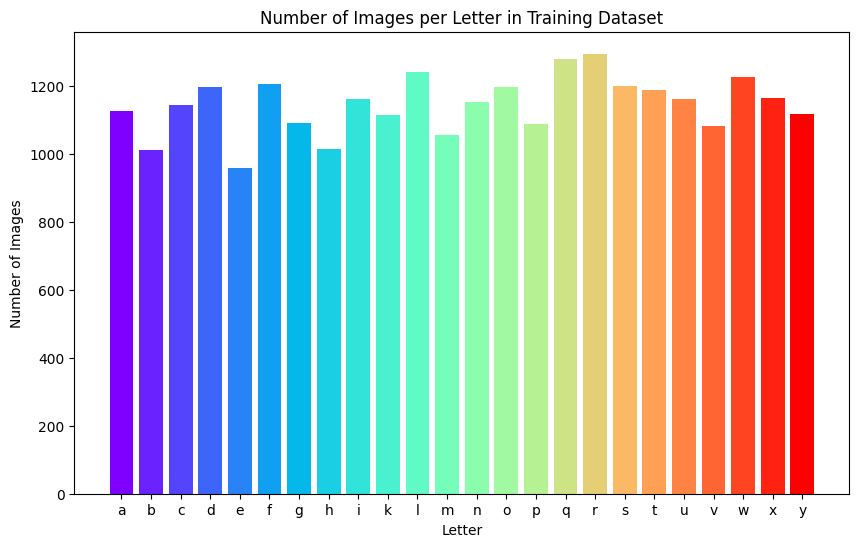

In [6]:
# Visualisation du nombre d'image par classe dans le jeu d'entraînement
letter_counts = {}
for label in y_train:
    letter = chr(label.item() + 97)  # Convertir le label en lettre (97 est le code ASCII pour 'a')
    if letter in letter_counts:
        letter_counts[letter] += 1
    else:
        letter_counts[letter] = 1

sorted_letters = sorted(letter_counts.keys())

# Créer l'histogramme
plt.figure(figsize=(10, 6))
colors = cm.rainbow(np.linspace(0, 1, len(sorted_letters)))
plt.bar(sorted_letters, [letter_counts[letter] for letter in sorted_letters], color=colors)
plt.xlabel('Letter')
plt.ylabel('Number of Images')
plt.title('Number of Images per Letter in Training Dataset')
plt.show()


In [7]:
history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

In [8]:
BATCH_SIZE = 32

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)

torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)

In [9]:
def fit(model, train_loader):
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    epochs = 15
    model.train()
    for epoch in range(epochs):
        correct = 0
        for batch_id , (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = loss_fn(output, var_y_batch)
            loss.backward()
            optimizer.step()

            # Compte le nombre de prédictions correctes
            prediction = torch.max(output.data, 1)[1] 
            correct += (prediction == var_y_batch).sum()
            if batch_id % 50 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_id*len(X_batch), len(train_loader.dataset), 100.*batch_id / len(train_loader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_id+1))))
            # if float(correct*100) / float(BATCH_SIZE*(batch_id+1)) > 90:
            #     break

In [10]:
# Nous devons redimensionner les données pour les passer dans le réseau de neurones convolutif
torch_X_train = torch_X_train.view(-1, 1,28,28).float()
torch_X_test = torch_X_test.view(-1,1,28,28).float()

train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# charge les données dans le DataLoader de PyTorch
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
 
cnn = CNN()
print(cnn)

it = iter(train_loader)
X_batch, y_batch = next(it)
print(cnn.forward(X_batch).shape)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=25, bias=True)
)
torch.Size([32, 128])


In [12]:
fit(cnn,train_loader)

Epoch : 0 [0/27455 (0%)]	Loss: 75.794220	 Accuracy:0.000%
Epoch : 0 [1600/27455 (6%)]	Loss: 3.578184	 Accuracy:4.350%
Epoch : 0 [3200/27455 (12%)]	Loss: 3.228750	 Accuracy:4.146%
Epoch : 0 [4800/27455 (17%)]	Loss: 3.450180	 Accuracy:4.325%
Epoch : 0 [6400/27455 (23%)]	Loss: 3.303173	 Accuracy:4.447%
Epoch : 0 [8000/27455 (29%)]	Loss: 3.032616	 Accuracy:5.354%
Epoch : 0 [9600/27455 (35%)]	Loss: 2.979439	 Accuracy:6.447%
Epoch : 0 [11200/27455 (41%)]	Loss: 2.861534	 Accuracy:7.719%
Epoch : 0 [12800/27455 (47%)]	Loss: 2.524137	 Accuracy:9.063%
Epoch : 0 [14400/27455 (52%)]	Loss: 1.995511	 Accuracy:10.830%
Epoch : 0 [16000/27455 (58%)]	Loss: 2.280657	 Accuracy:12.232%
Epoch : 0 [17600/27455 (64%)]	Loss: 1.948108	 Accuracy:13.714%
Epoch : 0 [19200/27455 (70%)]	Loss: 1.927261	 Accuracy:15.193%
Epoch : 0 [20800/27455 (76%)]	Loss: 2.067591	 Accuracy:16.585%
Epoch : 0 [22400/27455 (82%)]	Loss: 1.958348	 Accuracy:18.117%
Epoch : 0 [24000/27455 (87%)]	Loss: 1.872781	 Accuracy:19.591%
Epoch : 0 [2

In [13]:
def evaluate(model):
    correct = 0 
    for test_imgs, test_labels in test_loader:
        test_imgs = Variable(test_imgs).float()
        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()
    print("Test accuracy:{:.3f}% ".format( float(correct) / (len(test_loader)*BATCH_SIZE)))


In [18]:
evaluate(cnn)

Test accuracy:0.787% 


ValueError: x and y must have same first dimension, but have shapes (25,) and (5,)

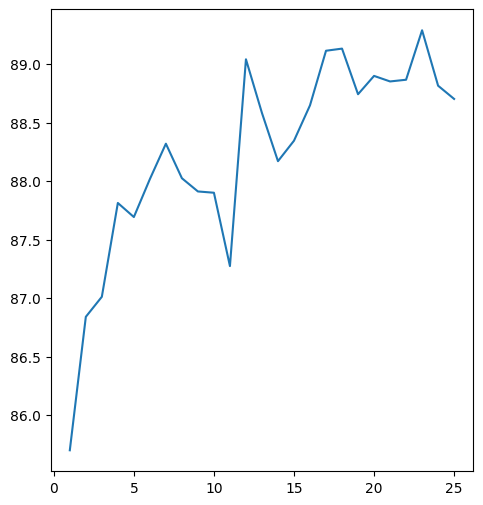

In [70]:
def plot_performance(history):
    epochs = len(history['train_loss'])
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), history['train_acc'], label='Training')
    plt.plot(range(1, epochs+1), history['test_acc'], label='Testing')
    plt.title('Accuracy of the model in training and testing')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_performance(history)
